In [33]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
from reservoirpy.observables import nrmse, rsquare

import reservoirpy as rpy

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

import reservoirpy as rpy

rpy.verbosity(0)  # no need to be too verbose here
rpy.set_seed(42)  # make everyhting reproducible !

In [34]:
from scipy.integrate import solve_ivp

def coupled_system(t, state, mu, sigma, rho, beta):
    X, Y, x_lorenz, y_lorenz, z_lorenz = state
    
    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X + x_lorenz
    
    dx_lorenz_dt = sigma * (y_lorenz - x_lorenz)
    dy_lorenz_dt = x_lorenz * (rho - z_lorenz) - y_lorenz
    dz_lorenz_dt = x_lorenz * y_lorenz - beta * z_lorenz
    
    return [dXdt, dYdt, dx_lorenz_dt, dy_lorenz_dt, dz_lorenz_dt]

mu = 1.0
sigma = 10.0
rho = 28.0
beta = 8/3
initial_state = [1.0, 0.0, 1.0, 1.0, 1.0]  # Initial states for [X, Y, x_lorenz, y_lorenz, z_lorenz]
t_span = (0, 2510)

sol = solve_ivp(coupled_system, t_span, initial_state, args=(mu, sigma, rho, beta), t_eval=np.linspace(t_span[0], t_span[1], 25100), max_step = 0.01)

In [35]:
data_loaded = pd.read_csv('coupled_system_dataset.csv')

In [36]:
#Time, Van Der Pol　OscillatorのX, lorenzのx項のみを抽出、学習。

data = pd.DataFrame({
    'X': sol.y[0],
    'Y': sol.y[1],
    'x_lorenz': sol.y[2],
    'y_lorenz': sol.y[3],
    'z_lorenz': sol.y[4]
})

# DataFrameをCSVファイルに保存
data.to_csv('coupled_system_dataset.csv', index=False)

In [37]:
X = data.values

In [38]:
X.shape

(25100, 5)

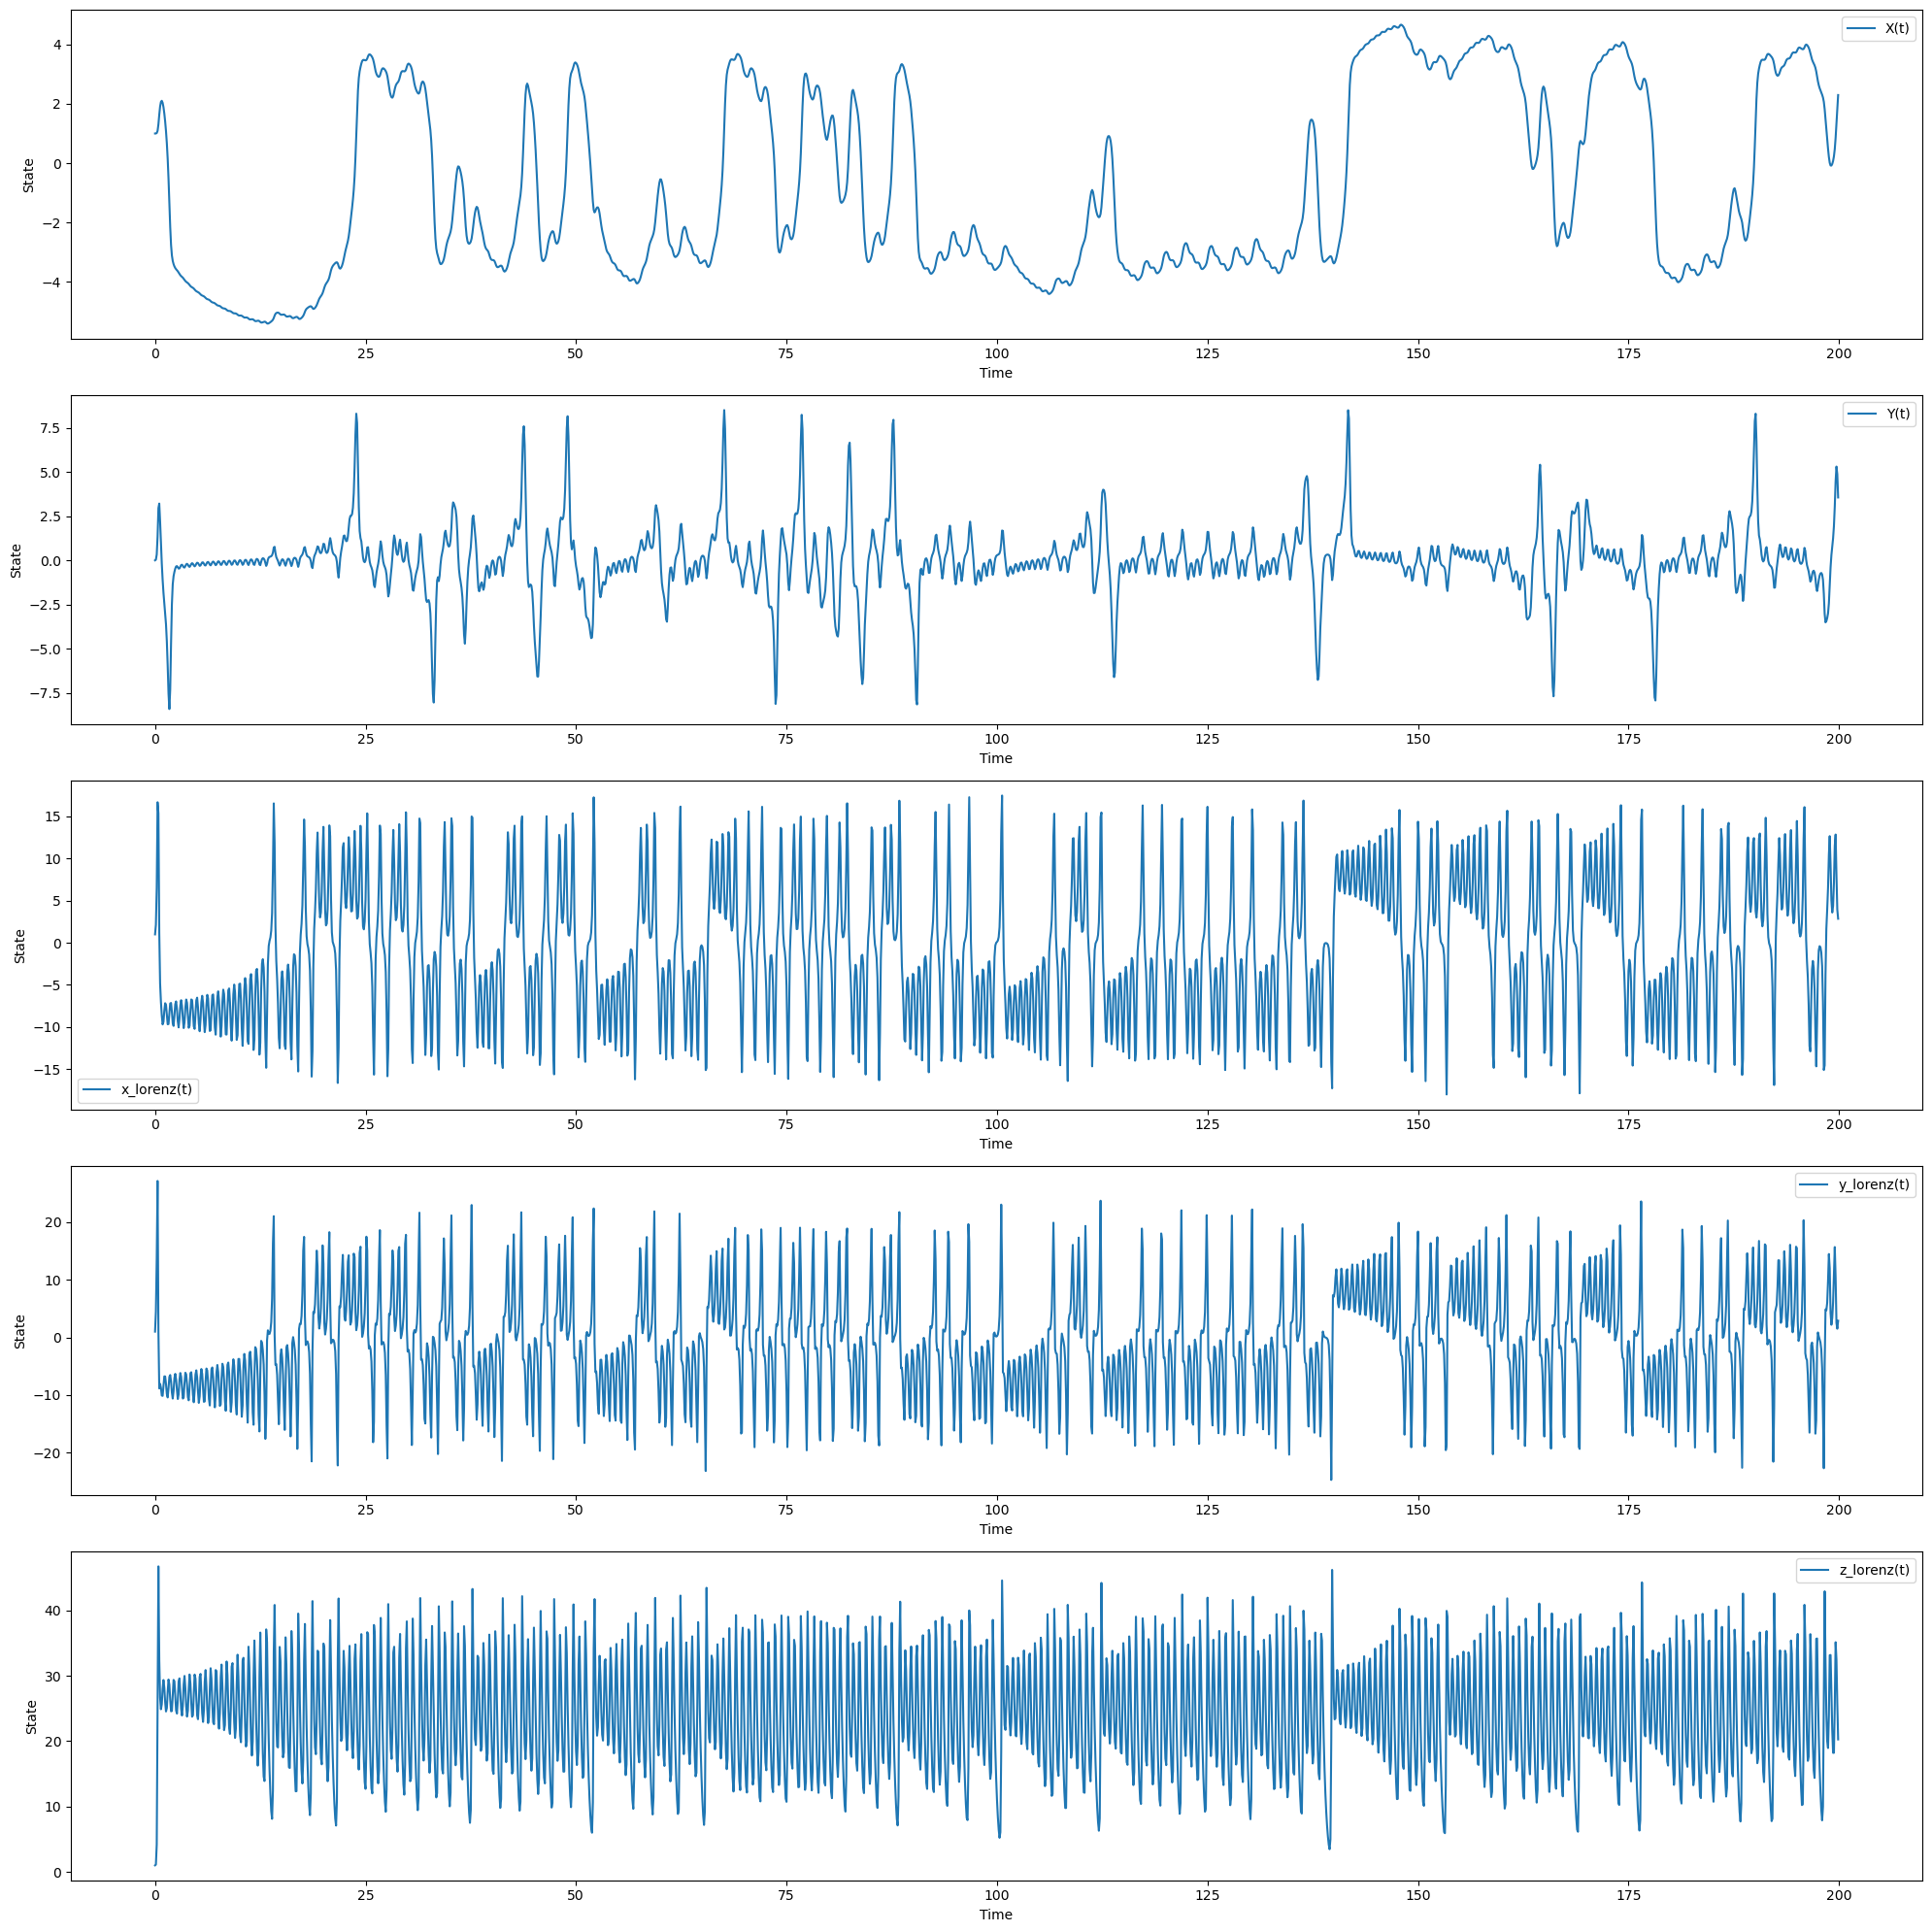

In [39]:
# Plot the results
sample = 2000

plt.figure(figsize=(20, 20))

plt.subplot(5, 1, 1)
plt.plot(sol.t[:sample], sol.y[0][:sample], label='X(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(sol.t[:sample], sol.y[1][:sample], label='Y(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(sol.t[:sample], sol.y[2][:sample], label='x_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(sol.t[:sample], sol.y[3][:sample], label='y_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(sol.t[:sample], sol.y[4][:sample], label='z_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.tight_layout()
plt.show()

# 何期先予測にするか

In [40]:
from reservoirpy.datasets import to_forecasting

train_len = 10000
test_len = 10000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+test_len], y[train_len:train_len+test_len]

dataset = ((X_train, y_train), (X_test, y_test))

In [41]:
# bestから取得したハイパーパラメータを設定
N = 3849
iss =  0.14258024657972923
lr = 0.5516837456874331
ridge = 3.7433235003717447e-07
seed = 1234
sr =  0.1931498404234262

In [42]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout

In [43]:
# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
esn_model = reservoir >> readout

# モデルの訓練と予測
predictions = esn_model.fit(X_train, y_train).run(X_test)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_test, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 8.473885849045176e-05
R^2: 0.999999722975628


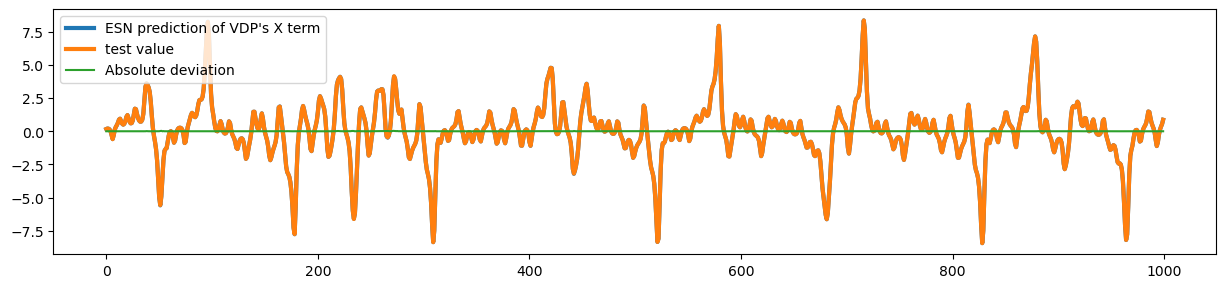

In [44]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 1:2][:sample], lw=3, label="ESN prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, 1:2][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 1:2][:sample] - predictions[:, 1:2][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

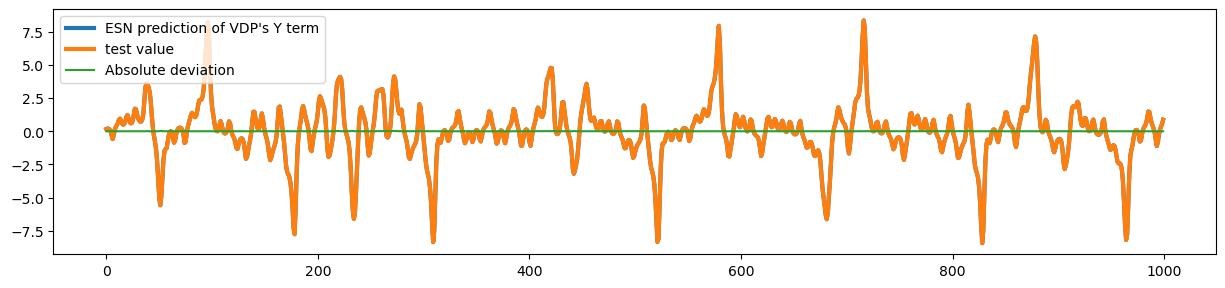

In [45]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 1:2][:sample], lw=3, label="ESN prediction of VDP's Y term")
plt.plot(np.arange(sample), y_test[:, 1:2][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 1:2][:sample] - predictions[:, 1:2][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

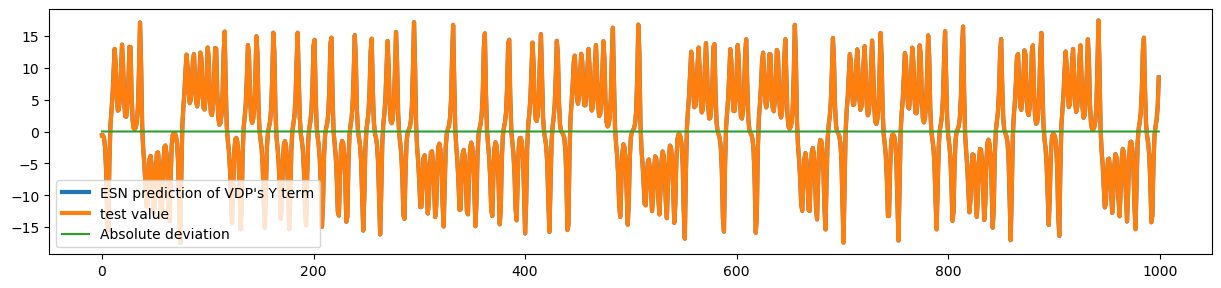

In [46]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 2:3][:sample], lw=3, label="ESN prediction of VDP's Y term")
plt.plot(np.arange(sample), y_test[:, 2:3][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 2:3][:sample] - predictions[:, 2:3][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

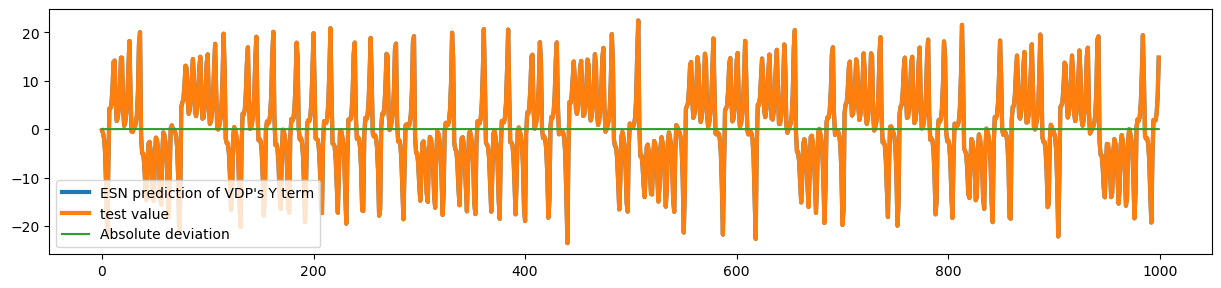

In [47]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 3:4][:sample], lw=3, label="ESN prediction of VDP's Y term")
plt.plot(np.arange(sample), y_test[:, 3:4][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 3:4][:sample] - predictions[:, 3:4][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

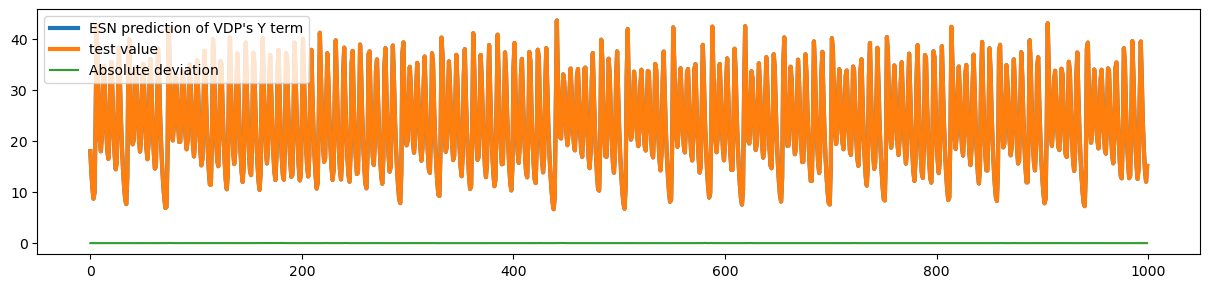

In [48]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 4:5][:sample], lw=3, label="ESN prediction of VDP's Y term")
plt.plot(np.arange(sample), y_test[:, 4:5][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 4:5][:sample] - predictions[:, 4:5][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

In [49]:
rsquare(y_test, predictions), nrmse(y_test, predictions)

(0.999999722975628, 8.678305379228906e-05)

In [50]:
rsquare(y_test[:, :2], predictions[:, :2]), nrmse(y_test[:, :2], predictions[:, :2])

(0.9999976084410793, 0.00023224118147844292)

最適化はVDPのX, Yのみに対して行なっている．上のグラフを見れば，Lorenzの各項においては誤差がそれなりにあるように見える．

### Generative Modelを使ってみる

考えることは以下の通り

1. Generative modelを更新するごとに、外力に関しては実データを用いる。
2. 一周期$2\pi$で約1日に相当する。最終的には14日程度の予測を行えるようにしたいので、約100程度の予測が出来れば十分である。
3. 今，データは0.1刻みで出力しているので，1000程度の長さの間予測が上手くいってそうであれば良い．

In [51]:
predictions[-5:]

array([[-1.17373409,  4.12857862,  5.45009103, -1.44351056, 31.62611389],
       [-0.73970672,  4.53959856,  0.99904309, -1.42234138, 23.83493311],
       [-0.26634182,  4.94649274, -0.42029371, -1.24699157, 18.23344144],
       [ 0.25028727,  5.37136982, -1.18488679, -2.0692828 , 14.08696121],
       [ 0.79968637,  5.52877497, -2.52183325, -4.51176168, 11.30837967]])

In [52]:
y_test[-5:]

array([[-1.17385033,  4.12480754,  5.45306304, -1.43732426, 31.62617195],
       [-0.73981484,  4.53533299,  0.99916423, -1.42090707, 23.83203076],
       [-0.26627993,  4.94674519, -0.42084834, -1.24633966, 18.23735167],
       [ 0.25040535,  5.37328087, -1.18577303, -2.06889976, 14.08585813],
       [ 0.79961765,  5.52864587, -2.522151  , -4.51061096, 11.30844894]])

In [53]:
gen = predictions[-1]
gen

array([ 0.79968637,  5.52877497, -2.52183325, -4.51176168, 11.30837967])

In [54]:
gen = gen.reshape(1, 5)

In [55]:
gen.shape

(1, 5)

In [56]:
y_test[-1:].reshape(1, 5).shape

(1, 5)

In [57]:
gen[:, 2:5] = y_test[-1:].reshape(1, 5)[:, 2:5]
gen

array([[ 0.79968637,  5.52877497, -2.522151  , -4.51061096, 11.30844894]])

In [58]:
y[train_len+test_len: train_len+test_len+10]

array([[  1.33148673,   4.94814546,  -5.71244635, -10.44666277,
         11.30657756],
       [  1.75402335,   3.33218031, -12.23093152, -19.81176398,
         21.13314221],
       [  1.97570488,   1.09849674, -15.72901182, -12.11666594,
         40.12562278],
       [  2.00092672,  -0.37415243,  -7.29455878,   2.05441109,
         34.98536078],
       [  1.93861627,  -0.74799759,  -0.7890467 ,   3.0122053 ,
         25.94271137],
       [  1.86514857,  -0.68781692,   1.58084471,   3.13285663,
         20.03506573],
       [  1.80516382,  -0.49440329,   3.18470332,   5.14889215,
         16.20410652],
       [  1.7710277 ,  -0.15355519,   6.03976274,  10.01543881,
         15.44338539],
       [  1.78440389,   0.48401015,  11.14703987,  16.81522066,
         22.37748041],
       [  1.87849446,   1.40823982,  14.19066   ,  12.7039248 ,
         36.08292592]])

In [59]:
gen = esn_model(gen)
gen

array([[  1.33158368,   4.94900639,  -5.708323  , -10.44144424,
         11.3105565 ]])

In [60]:
y[train_len+test_len].reshape(1, 5)[:, 2:5]

array([[ -5.71244635, -10.44666277,  11.30657756]])

In [61]:
gen[:, 2:5] = y[train_len+test_len].reshape(1, 5)[:, 2:5]
gen

array([[  1.33158368,   4.94900639,  -5.71244635, -10.44666277,
         11.30657756]])

In [62]:
gen = esn_model(gen)
gen

array([[  1.75398235,   3.32542615, -12.22881557, -19.80293988,
         21.12068258]])

In [63]:
current_gen = gen
current_gen 

array([[  1.75398235,   3.32542615, -12.22881557, -19.80293988,
         21.12068258]])

In [64]:
import numpy as np

nb_generations = 100

# 保存用のnumpy配列を初期化
current_gens = np.zeros((nb_generations, current_gen.shape[0], current_gen.shape[1]))
true_values = np.zeros((nb_generations, y[train_len+test_len+1].shape[0]))
deviations = np.zeros_like(true_values)
nrmse_values = np.zeros(nb_generations)
updated_current_gens = np.zeros_like(current_gens)

for t in range(nb_generations):
    reset_esn()
    
    true_lorenz = y[train_len+test_len+t+1].reshape(1, 5)[:, 2:5]
    current_gen[:, 2:5] = true_lorenz

    # 配列にデータを追加
    current_gens[t] = current_gen
    true_values[t] = y[train_len+test_len+1+t]
    deviations[t] = y[train_len+test_len+1+t] - current_gen
    nrmse_value = nrmse(y[train_len+test_len+1+t].reshape(1, 5), current_gen.reshape(1, 5))
    nrmse_values[t] = nrmse_value

    # プリントアウト
    print(f"{t}回目の試行：{current_gen}:current_gen")
    print(f"{t}回目の試行：{y[train_len+test_len+1+t]}:実際の値")
    print(f"{t}回目の試行：{deviations[t]}:偏差")
    print(f"{t}回目の試行：{nrmse_value}:偏差")

    current_gen = esn_model(current_gen)
    updated_current_gens[t] = current_gen

    print(f"{t}回目の試行：{current_gen}:更新したcurrent_genの値\n")


0回目の試行：[[  1.75398235   3.32542615 -12.23093152 -19.81176398  21.13314221]]:current_gen
0回目の試行：[  1.75402335   3.33218031 -12.23093152 -19.81176398  21.13314221]:実際の値
0回目の試行：[4.09964643e-05 6.75415829e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00]:偏差
0回目の試行：7.377247468715467e-05:偏差
0回目の試行：[[  1.97408152   1.06966795 -15.72598013 -12.09612736  40.12044151]]:更新したcurrent_genの値

1回目の試行：[[  1.97408152   1.06966795 -15.72901182 -12.11666594  40.12562278]]:current_gen
1回目の試行：[  1.97570488   1.09849674 -15.72901182 -12.11666594  40.12562278]:実際の値
1回目の試行：[0.00162336 0.02882878 0.         0.         0.        ]:偏差
1回目の試行：0.00023119026621990738:偏差
1回目の試行：[[ 1.9970752  -0.38005967 -7.28666184  2.06856465 35.00134588]]:更新したcurrent_genの値

2回目の試行：[[ 1.9970752  -0.38005967 -7.29455878  2.05441109 34.98536078]]:current_gen
2回目の試行：[ 2.00092672 -0.37415243 -7.29455878  2.05441109 34.98536078]:実際の値
2回目の試行：[0.00385152 0.00590723 0.         0.         0.        ]:偏差
2回目の試行：7.459131608982972e-05:偏差
2回目の試

83回目の試行：[[  2.72049977  -1.42310962  -9.42437416 -11.96050527  24.64882807]]:更新したcurrent_genの値

84回目の試行：[[  2.72049977  -1.42310962  -9.4217928  -11.94943273  24.64610068]]:current_gen
84回目の試行：[  2.71253158  -1.4305167   -9.4217928  -11.94943273  24.64610068]:実際の値
84回目の試行：[-0.00796819 -0.00740709  0.          0.          0.        ]:偏差
84回目の試行：0.0001329486307864211:偏差
84回目の試行：[[  2.56095033  -1.78114328 -11.09301559 -11.3605301   30.0110038 ]]:更新したcurrent_genの値

85回目の試行：[[  2.56095033  -1.78114328 -11.09132341 -11.35996054  30.01139432]]:current_gen
85回目の試行：[  2.55224164  -1.78807365 -11.09132341 -11.35996054  30.01139432]:実際の値
85回目の試行：[-0.00870869 -0.00693036  0.          0.          0.        ]:偏差
85回目の試行：0.0001203096274469235:偏差
85回目の試行：[[ 2.36565797 -2.10158861 -9.66077973 -6.93090947 31.50888965]]:更新したcurrent_genの値

86回目の試行：[[ 2.36565797 -2.10158861 -9.66205957 -6.93822491 31.50871888]]:current_gen
86回目の試行：[ 2.35607883 -2.11133325 -9.66205957 -6.93822491 31.50871888]:実際の値
86回目の試行：

しかし，これほど悪くはなかったのでは？
チュートリアルの方法では，最初の数十回はうまくいってるように見えた．
もしかすると，グラフが潰れて見えていただけで，本当は全く精度が良くなかったのかもしれない．